## 1. Prepare Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, confusion_matrix, roc_curve, roc_auc_score

from aequitas.group import Group

In [2]:
X_test = pd.read_csv("X_test_oh.csv")

In [3]:
X_train = pd.read_csv("X_train_oh.csv")

In [4]:
X_val = pd.read_csv("X_val_oh.csv")

In [5]:
y_test = pd.read_csv("y_test_oh.csv")

In [6]:
y_train = pd.read_csv("y_train_oh.csv")

In [7]:
y_val = pd.read_csv("y_val_oh.csv")

In [8]:
y_test = np.array(y_test).ravel()

In [9]:
y_train = np.array(y_train).ravel()

In [10]:
y_val = np.array(y_val).ravel()

## 2. Define Matrics - performance & fairness

In [11]:
X_test["customer_age"]

0         50
1         20
2         30
3         40
4         20
          ..
108163    60
108164    30
108165    40
108166    40
108167    40
Name: customer_age, Length: 108168, dtype: int64

In [12]:
def Plot_ROC(fpr, tpr):
    plt.plot(fpr, tpr, label = 'ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

In [13]:
# focus on age group for now
from IPython.display import display
def Get_fairness_metrics(y_true, y_pred, groups, FIXED_FPR = 0.05):
    # aequitas.group
    g = Group()
    aequitas_df = pd.DataFrame(
        {"score": y_pred,
         "label_value": y_true,
         "group": groups}
    )
    # Use aequitas to compute confusion matrix metrics for every group.
    disparities_df = g.get_crosstabs(aequitas_df, score_thresholds={"score_val": [FIXED_FPR]})[0]
    print("This is the disparities df:")
    display(disparities_df)
    predictive_equality = disparities_df["fpr"].min() / disparities_df["fpr"].max()

    return predictive_equality, disparities_df

In [14]:
def Evaluation(predictions, ground_truth, X, FIXED_FPR=0.05):
    result = []
    fprs, tprs, thresholds = roc_curve(ground_truth, predictions) 
    Plot_ROC(fprs, tprs)
    
    tpr = tprs[fprs < FIXED_FPR][-1]
    fpr = fprs[fprs < FIXED_FPR][-1]
    threshold = thresholds[fprs < FIXED_FPR][-1]
    
    pd.set_option('display.max_columns', None)  # Show all columns
    
    # print("AUC:", roc_auc_score(ground_truth, predictions))
    
    print(f"Fixed FPR: {round(fpr, 4)}")
    
    groups = (X["customer_age"] > 50).map({True: ">50", False: "<=50"})  # Define the group
    predictive_equality, disparities_df = Get_fairness_metrics(ground_truth, predictions, groups, FIXED_FPR)

    # print(f"TPR under the threshold: {round(tpr, 4)}")
    print(f"Predictive Equality: {round(predictive_equality, 4)}")
    
    result.append(round(tpr, 4))
    result.append(round(predictive_equality, 4))
    
    return result

## 3. Modeling

### 3.1 vanilla logistic model

In [15]:
lr_0 = LogisticRegression()
lr_0.fit(X_train, y_train)
y_pred = lr_0.predict_proba(X_test)[:,1]

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


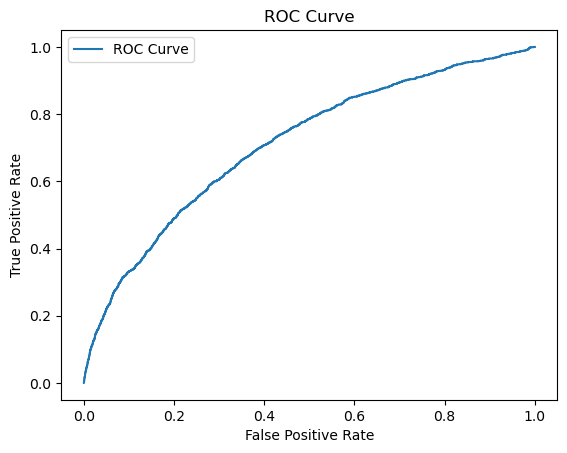

Fixed FPR: 0.05
This is the disparities df:


,model_id,score_threshold,k,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,0.05_val,13736,group,<=50,0.879280,0.335994,0.88597,0.009145,0.964987,0.11403,0.664006,0.990855,0.035013,12024,90983,0.875364,0.116730,11603,832,90151,421,1253,101754,103007,108168,0.012164
1,0,0.05_val,13736,group,>50,0.668475,0.502538,0.67506,0.028414,0.942173,0.32494,0.497462,0.971586,0.057827,1712,3449,0.124636,0.331719,1613,98,3351,99,197,4964,5161,108168,0.038171


Predictive Equality: 0.3509


[0.2214, 0.3509]

In [16]:
Evaluation(y_pred, y_test, X = X_test)

### 3.2 logistic model change slover to 'newton-cholesky' as it performs good when sample >> features

In [17]:
lr_1 = LogisticRegression(solver = 'newton-cholesky')
lr_1.fit(X_train, y_train)
y_pred = lr_1.predict_proba(X_test)[:,1]

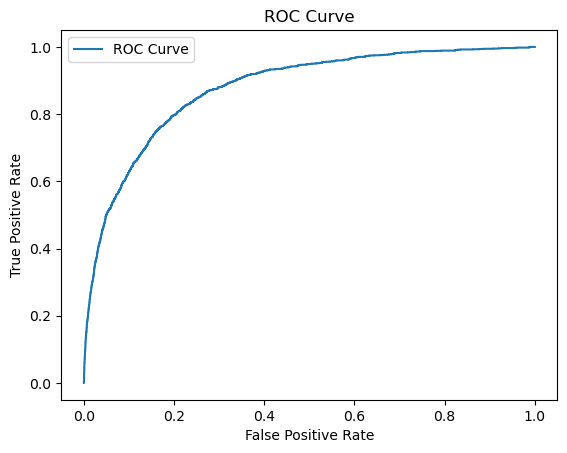

Fixed FPR: 0.0499
This is the disparities df:


,model_id,score_threshold,k,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,0.05_val,4328,group,<=50,0.961187,0.379090,0.968355,0.007834,0.871448,0.031645,0.620910,0.992166,0.128552,3695,99312,0.853743,0.035871,3220,778,98534,475,1253,101754,103007,108168,0.012164
1,0,0.05_val,4328,group,>50,0.890719,0.675127,0.899275,0.014134,0.789889,0.100725,0.324873,0.985866,0.210111,633,4528,0.146257,0.122651,500,64,4464,133,197,4964,5161,108168,0.038171


Predictive Equality: 0.3142


[0.5014, 0.3142]

In [18]:
Evaluation(y_pred, y_test, X = X_test)

### How to interpret this model?
As the author (Pedro Saleiro) of thr paper said, they are interested in finding the models with highest TPR above 0.8 predictive equality.

The lr_1 has a TPR of 50.14% and Predictive Equality of 31.42%, means the model is not ideal.

### 3-2. fine-tuned logistic model, with feature engineering and hyperparameter select.

In [19]:
# 1st, apply log transformation on X_train, X_test, and X_val dataset for [prev_address_months_count, current_address_months_count, days_since_request, intended_balcon_amount, bank_branch_count_8w, bank_months_count, session_length_in_minutes].
# Based on the EDA result in another ipynb, we apply log transformation on these highly right-skewed features.
features_to_log_transform = [
    'prev_address_months_count', 
    'days_since_request', 
    'intended_balcon_amount', 
    'bank_branch_count_8w', 
    'bank_months_count', 
    'session_length_in_minutes'
]

In [20]:
def log_transform(df, features):
    for feature in features:
        df[feature] = df[feature].apply(lambda x: np.log1p(x) if x >= 0 else x)
    return df

In [21]:
# apply log-transformation
X_train_transformed = log_transform(X_train.copy(), features_to_log_transform)
X_test_transformed = log_transform(X_test.copy(), features_to_log_transform)
X_val_transformed = log_transform(X_val.copy(), features_to_log_transform)

In [22]:
print(X_train_transformed.shape, X_test_transformed.shape, X_val_transformed.shape)
print(y_train.shape, y_test.shape, y_val.shape)

(794989, 50) (108168, 50) (96843, 50)
(794989,) (108168,) (96843,)


In [23]:
# newton-cg
# newton-cholesky
lr_3 = LogisticRegression(solver = 'newton-cg')
lr_3.fit(X_train_transformed, y_train)
y_pred_3 = lr_3.predict_proba(X_test_transformed)[:,1]

/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


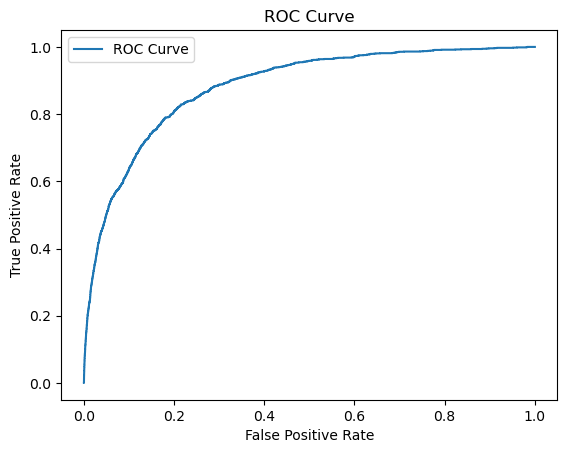

Fixed FPR: 0.0497
This is the disparities df:


,model_id,score_threshold,k,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,0.05_val,4672,group,<=50,0.958595,0.411812,0.965328,0.007447,0.872404,0.034672,0.588188,0.992553,0.127596,4044,98963,0.865582,0.039259,3528,737,98226,516,1253,101754,103007,108168,0.012164
1,0,0.05_val,4672,group,>50,0.892463,0.685279,0.900685,0.013677,0.785032,0.099315,0.314721,0.986323,0.214968,628,4533,0.134418,0.121682,493,62,4471,135,197,4964,5161,108168,0.038171


Predictive Equality: 0.3491


[0.5034, 0.3491]

In [24]:
Evaluation(y_pred_3, y_test, X = X_test_transformed)

In [ ]:
C_values = [0.0001, 0.001, 0.01, 0.02, 0.1]  # Regularization parameter
max_iter_values = [200, 300, 400, 500]    # Maximum number of iterations
available_slovers = ['newton-cg', 'newton-cholesky']

best_score = 0  
best_params = {}

# Iterate through hyperparameters
for C in C_values:
    for the_slover in available_slovers:
        for max_iter in max_iter_values:
            # Define and train Logistic Regression model with current hyperparameters
            print("A model is being trained")
            lr_model = LogisticRegression(solver=the_slover, C=C, max_iter=max_iter)
            lr_model.fit(X_train_transformed, y_train)
        
            y_pred_val = lr_model.predict_proba(X_val_transformed)[:, 1]
            # Current performance
        
            current_score = Evaluation(y_pred_val, y_val, X = X_val_transformed)[0]
            # Update best score and parameters if current model performs better
            if current_score > best_score:
                best_score = current_score
                best_params = {'C': C, 'max_iter': max_iter, 'slover':the_slover}
                print("curr best parameters:", best_params)

# Train the best model
best_lr_model = LogisticRegression(**best_params)
best_lr_model.fit(X_train_transformed, y_train)

# Make predictions with the best model
y_pred_2 = best_lr_model.predict_proba(X_test_transformed)[:, 1]

# Calculate the evaluation metric
evaluation_result = Evaluation(y_pred_2, y_test)[0]

# Print the best parameters and evaluation result
print("Best Parameters:", best_params)
print("Evaluation Result:", evaluation_result)

A model is being trained
